In [54]:
import sys
 
sys.path.append('..')

from sklearn.covariance import graphical_lasso, EmpiricalCovariance, LedoitWolf
from GraphModels.model import DiagDominantPcorrModel
from sklearn.metrics import accuracy_score, matthews_corrcoef
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
from scipy.stats import multivariate_normal, multivariate_t, kendalltau
import multiprocessing as mp

import logging
import warnings
from collections import defaultdict
import pickle
import random
import networkx as nx
import os
from datetime import datetime

from correlation_utils import *

In [2]:
logging.getLogger().setLevel(logging.INFO)
warnings.filterwarnings('ignore')

# Utility functions

In [74]:
def sample_from_mixed(n, cov, eps, dof):
    dim = cov.shape[0]
    t_cov_scaler = (dof - 2) / dof
    norm_samples = multivariate_normal.rvs(np.zeros(dim), cov, size=n)
    t_samples = multivariate_t.rvs(np.zeros(dim), t_cov_scaler * cov, df=dof, size=n)
    selector = (np.random.uniform(0, 1, size=n) < eps).astype(int)
    result = norm_samples.T * (1 - selector) + t_samples.T * selector
    return result.T

def flatten_labels(true_adj, pred_adj):
    n = true_adj.shape[0]
    true_labels = true_adj[np.triu_indices(n, k=1)]
    pred_labels = pred_adj[np.triu_indices(n, k=1)]

    return true_labels, pred_labels

def adjacency_from_precision(precision):
    return (precision != 0.).astype(int)

def inner_given_model_experiment(model, S_obs, reg_param, eps_list, n, t_dof, glasso_max_iter, get_cov_estim):
    local_data = defaultdict(list)
    for eps in eps_list:
        total_skipped = 0
        for n_repl in range(S_obs):
            data = sample_from_mixed(n, model.covariance, eps, t_dof)
            cov_estim = get_cov_estim(data)
            try:
                gl_cov, gl_prec = graphical_lasso(cov_estim, alpha=reg_param, max_iter=glasso_max_iter)

                pred_prec = gl_prec
                true_prec = model.precision

                true, pred = flatten_labels(true_prec, pred_prec)
                local_data[eps].append((true, pred))
            except FloatingPointError as e:
                total_skipped += 1
    return local_data

def run_experiments(S_sg, S_obs, N, density, reg_param, eps_list, n, t_dof, glasso_max_iter, get_cov_estim, model_list=None, **kwargs):
    experiment_data = defaultdict(list)

    if model_list == None:
        models = [DiagDominantPcorrModel(N, density) for _ in range(S_sg)]
    else:
        models = model_list

    with mp.Pool() as pool:
        waiters = [
            pool.apply_async(inner_given_model_experiment, (model, S_obs, reg_param, eps_list, n, t_dof, glasso_max_iter, get_cov_estim))
            for model in models
        ]

        for waiter in tqdm(waiters, gui=False):
            process_dict = waiter.get()
            for k in eps_list:
                experiment_data[k].extend(process_dict[k])

    return experiment_data

def apply_metric(data, eps_list, metric):
    res = []
    for k in tqdm(eps_list):
        res.append(np.array([metric(v[0], v[1]) for v in data[k]]).mean())
    
    return res

def derive_covariance_from(corr_mat, variances):
    pearson_corr = np.sin(np.pi / 2 * corr_mat)
    D = np.diag(np.sqrt(variances))

    return D @ pearson_corr @ D

def pearson_cov_estim(data):
    return EmpiricalCovariance(assume_centered=True, store_precision=False).fit(data).covariance_

def kendall_cov_estim(data):
    corr_mat = kendall_corr_mat(data)
    variance = np.var(data, axis=0)

    return derive_covariance_from(corr_mat, variance)

def fechner_cov_estim(data):
    corr_mat = fechner_corr_mat(data)
    variance = np.var(data, axis=0)

    return derive_covariance_from(corr_mat, variance)

def log_experiment_metadata(obj):
    logging.info("Reading experiment...")
    logging.info(f"Experiment was conducted at {obj['datetime']}")
    logging.info("--- Experiment parameters ---")
    for k, v in obj['config'].items():
        logging.info(f"\t{k}: {v}")

def experiment_run_and_store(outdir, experiment_config, s_param_variants):
    if not os.path.isdir(outdir):
        os.mkdir(outdir)

    get_cov_method = s_param_variants[experiment_config['get_s_method']]
    logging.info("--- Experiment parameters ---")
    for k, v in experiment_config.items():
        logging.info(f"\t{k}: {v}")

    experiment_data = run_experiments(**experiment_config, get_cov_estim=get_cov_method)
    ofname = f"{experiment_config['get_s_method'].lower().replace(' ', '_')}_n{experiment_config['n']}.bin"

    data_and_config = {'config': experiment_config, 'data': experiment_data, 'datetime': datetime.now()}

    with open(os.path.join(outdir, ofname), 'wb') as f:
        pickle.dump(data_and_config, f)

    return experiment_data

def load_stored_experiment(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)

    log_experiment_metadata(data)

    return data['config'], data['data'], data['datetime']

In [75]:
s_param_variants = {
    'Pearson correlations': pearson_corr_mat,
    'Pearson correlations via Kendall correlations': pearson_corr_via_kendall,
    'Pearson correlations via Fechner correlations': pearson_corr_via_fechner,
}

In [76]:
sample_config = {
    'N': 20,
    'n': 100,
    'S_obs': 1,
    'S_sg': 1,
    'reg_param': 0.1,
    'eps_list': np.linspace(0, 1, num=10),
    'density': 0.2,
    't_dof': 3,
    'glasso_max_iter': 500,
    'get_s_method': 'Pearson correlations via Kendall correlations',
}

experiment_run_and_store('robust_experiments', sample_config, s_param_variants)

INFO:root:--- Experiment parameters ---
INFO:root:	N: 20
INFO:root:	n: 100
INFO:root:	S_obs: 1
INFO:root:	S_sg: 1
INFO:root:	reg_param: 0.1
INFO:root:	eps_list: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
INFO:root:	density: 0.2
INFO:root:	t_dof: 3
INFO:root:	glasso_max_iter: 500
INFO:root:	get_s_method: Pearson correlations via Kendall correlations
100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


defaultdict(list,
            {0.0: [(array([ 0.        ,  0.        ,  0.        ,  0.        , -0.11759092,
                       0.        ,  0.        , -0.03200346,  0.        ,  0.        ,
                      -0.11388075,  0.        ,  0.        ,  0.01760307,  0.        ,
                       0.        ,  0.        ,  0.00433683,  0.        ,  0.        ,
                       0.        ,  0.        ,  0.10569889,  0.        , -0.04722873,
                      -0.00358877,  0.        , -0.01140143,  0.        ,  0.1363714 ,
                       0.        ,  0.        , -0.22011473,  0.        ,  0.        ,
                       0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                      -0.03130775,  0.        ,  0.        ,  0.        ,  0.        ,
                      -0.01565793,  0.        ,  0.        ,  0.        ,  0.        ,
                       0.        ,  0.14891394,  0.        , -0.05996779,  0.        ,
                    

In [77]:
load_stored_experiment('robust_experiments/pearson_correlations_via_kendall_correlations_n100.bin')

INFO:root:Reading experiment...
INFO:root:Experiment was conducted at 2024-02-24 22:08:00.162342
INFO:root:--- Experiment parameters ---
INFO:root:	N: 20
INFO:root:	n: 100
INFO:root:	S_obs: 1
INFO:root:	S_sg: 1
INFO:root:	reg_param: 0.1
INFO:root:	eps_list: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
INFO:root:	density: 0.2
INFO:root:	t_dof: 3
INFO:root:	glasso_max_iter: 500
INFO:root:	get_s_method: Pearson correlations via Kendall correlations


({'N': 20,
  'n': 100,
  'S_obs': 1,
  'S_sg': 1,
  'reg_param': 0.1,
  'eps_list': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
         0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
  'density': 0.2,
  't_dof': 3,
  'glasso_max_iter': 500,
  'get_s_method': 'Pearson correlations via Kendall correlations'},
 defaultdict(list,
             {0.0: [(array([ 0.        ,  0.        ,  0.        ,  0.        , -0.11759092,
                        0.        ,  0.        , -0.03200346,  0.        ,  0.        ,
                       -0.11388075,  0.        ,  0.        ,  0.01760307,  0.        ,
                        0.        ,  0.        ,  0.00433683,  0.        ,  0.        ,
                        0.        ,  0.        ,  0.10569889,  0.        , -0.04722873,
                       -0.00358877,  0.        , -0.01140143,  0.        ,  0.1363714 ,
                        0.        ,  0.        , -0.22011473,  0.        ,  0.        ,
            

# Parameters

In [77]:
N = 20
S_obs = 50
S_sg = 100
reg_param = 0.1
eps_list = np.linspace(0, 1, num=10)
n = 40
density = 0.2
t_dof = 3
glasso_max_iter=500

In [5]:
pregen_models = [DiagDominantPcorrModel(N, density) for _ in range(S_sg)]

with open(f'PREGEN_{S_sg}_models.bin', 'wb') as f:
    pickle.dump(pregen_models, f)

In [78]:
np.random.seed(1890)
random.seed(1890)

In [79]:
experiment_data = run_experiments(S_sg, S_obs, N, density, reg_param, eps_list, n, t_dof, glasso_max_iter, pearson_cov_estim)

100%|██████████| 100/100 [26:35<00:00, 15.96s/it] 


In [37]:
experiment_data[0]

[(array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
         0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
with open('last_experiment_data.bin', 'wb') as f:
    pickle.dump(experiment_data, f)

In [67]:
for k, v in experiment_data.items():
    print(f"{np.around(k, 2)}: {S_obs * S_sg - len(v)} ({(1 - len(v) / S_obs / S_sg) * 100}%)")

0.0: 0 (0.0%)
0.11: 1 (0.019999999999997797%)
0.22: 0 (0.0%)
0.33: 3 (0.060000000000004494%)
0.44: 1 (0.019999999999997797%)
0.56: 5 (0.09999999999998899%)
0.67: 2 (0.0400000000000067%)
0.78: 5 (0.09999999999998899%)
0.89: 5 (0.09999999999998899%)
1.0: 3 (0.060000000000004494%)


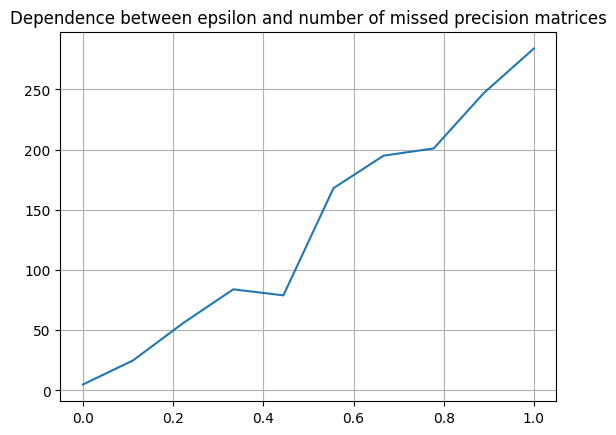

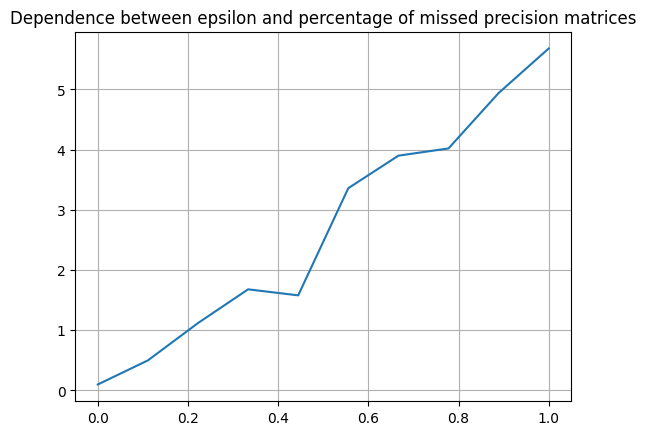

In [23]:
abs_missed = []
rel_missed = []

for k in eps_list:
    v = experiment_data[k]
    abs_missed.append(S_obs * S_sg - len(v))
    rel_missed.append((1 - len(v) / S_obs / S_sg) * 100)

plt.plot(eps_list, abs_missed)
plt.title("Dependence between epsilon and number of missed precision matrices")
plt.grid()
plt.show()

plt.plot(eps_list, rel_missed)
plt.title("Dependence between epsilon and percentage of missed precision matrices")
plt.grid()
plt.show()

In [80]:
x = eps_list
y = apply_metric(experiment_data, eps_list, matthews_corrcoef)

100%|██████████| 10/10 [00:41<00:00,  4.11s/it]


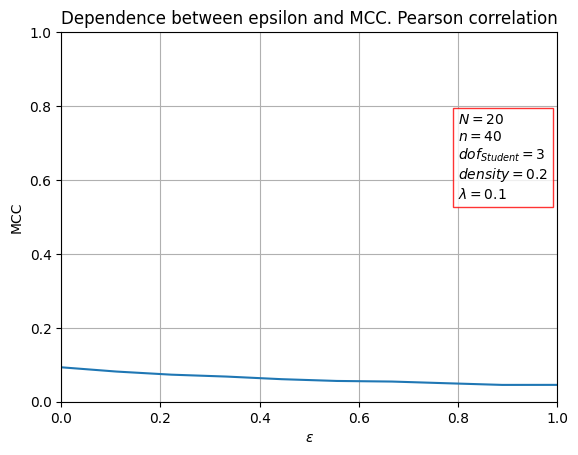

In [81]:
plt.plot(x, y)
plt.text(0.8, 0.55, "$N=20$\n$n=40$\n$dof_{Student}=3$\n$density=0.2$\n$\lambda=0.1$", bbox=dict(facecolor='white', edgecolor='red', alpha=0.8))
plt.title("Dependence between epsilon and MCC. Pearson correlation")
plt.xlabel('$\epsilon$')
plt.ylabel('MCC')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
plt.show()